# `microguilds` tutorial
This tutorial will guide you through a use case using a mock mastertable.

### Table of contents
1. Enrichment analysis.
2. Filtering significant nodes. 
3. Clustering the phylogenetic tree.
4. Sample placement.
5. Compute a guilds' k tensor. 
6. Visualize a guilds' k tensor.
7. Interpret the results.

### Import libraries


In [34]:
import warnings
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import functional_clustering_utils as fcutils
from tqdm import tqdm

### Setup important variables

In [35]:
# Input
GENE = "mocK"
FILENAME_ENV_DATA = './environmental_data_mock.csv'
FILENAME_TREE = f'./{GENE}_tree.newick'

# Others
MCMAX = 9999

### 1. Enrichment analysis

##### First load environmental data

In [36]:
# Load environmental feature matrix
df = pd.read_csv(FILENAME_ENV_DATA, sep=";", encoding='utf8')
ft = df.to_numpy()

# Extract useful info
SPECIES_NAMES = np.array([line[0] for line in ft])
FEATURES_NAMES = np.array([col for col in df.columns])[1:16]
FEATURES_SPECIES = np.array([line[1:16] for line in ft])
NFEATURES = FEATURES_SPECIES.shape[1]

print(f"Succesfully loaded {FILENAME_ENV_DATA}")
df.head(12)

Succesfully loaded ./environmental_data_mock.csv


,organism,temp,pH
0,Vibrio fictivorax,37,4
1,Salmonella imagina,36,4
2,Escherichia ficticola,37,7
3,Mycobacterium fictum,34,7
4,Lactobacillus fictobacter,15,8
5,Bacillus fictilis,13,8
6,Acinetobacter imaginensis,14,8
7,Pseudomonas fictosa,15,4
8,Streptomyces fictivus,14,5
9,Bacteroides fictus,15,5


##### Now load the phylogenetic tree

In [37]:
# Compute clade data
data = fcutils.get_clade_data(
    FILENAME_TREE,
    treetype="newick",
    filename_out=None
)

# Extract important variables
clade_ids, clade_lfs, clade_dpt, leaf_names = data

GENUS = np.array([fcutils.get_genus(name) for name in leaf_names])
SPECIES = np.array([fcutils.get_species(name) for name in leaf_names])
NLEAFS = len(leaf_names)
NCLADES = len(clade_ids)
CLADE_NLEAFS = np.array([len(leafs) for leafs in clade_lfs])

100%|██████████| 8/8 [00:00<00:00, 2627.60it/s]


Data loaded from ./mocK_tree.newick.
Found data for > 11 leafs,
               > 8 internal nodes.


##### Build the features matrix

Find for which organism of the tree we have environmental info in the table, and build a features matrix. 

Observe that there is missing environmental data for just one organism.

In [38]:
print("")

FEATURES = np.zeros((NLEAFS, NFEATURES)) * np.nan

# Fill feature matrix of the organisms found in the tree
for idx_sp, species in tqdm(enumerate(SPECIES_NAMES)):
    _speacies_name = species.split(' ')
    for idx_leaf, leaf in enumerate(leaf_names):
        # If "species" is matched to the tree "leaf"
        if (_speacies_name[0] in leaf) and (_speacies_name[1] in leaf):
            FEATURES[idx_leaf, :] = FEATURES_SPECIES[idx_sp, :]

_missing_data = np.sum(np.all(np.isnan(FEATURES), axis=1))
_not_missing_data = FEATURES.shape[0] - _missing_data
idx_missing = np.argwhere(np.all(np.isnan(FEATURES), axis=1))[:, 0]
print(f'\nData obtained for {_not_missing_data} tree entries.')
print(f'Data missing  for {_missing_data} tree entries.')
_ = [print(f"  -[{_:4d}] {GENUS[_]} {SPECIES[_]}") for _ in idx_missing]

10it [00:00, 9913.27it/s]


Data obtained for 10 tree entries.
Data missing  for 1 tree entries.
  -[   9] Clostridium imaginarium


And now randomize values and compute the enrichment as z-scores.

In [39]:
# Declare accumulators
ZSCORES = np.zeros((NCLADES, NFEATURES)) * np.nan

# Compute randomizations for every internal node
for idx_clade, _leafs in tqdm(enumerate(clade_lfs), total=NCLADES):
    
    # Compute true observed values for each feature
    obs_mean = np.nanmean(FEATURES[_leafs, :], axis=0)

    # Randomize values
    values_mc = np.zeros((MCMAX, NFEATURES))
    for imc in range(MCMAX):
        rr = np.random.permutation(NLEAFS)[:len(_leafs)]
        values_mc[imc, :] = np.nanmean(FEATURES[rr, :], axis=0)

    # Compute and store z-scores
    mc_mean = np.nanmean(values_mc, axis=0)
    mc_std = np.nanstd(values_mc, axis=0)
    mc_std[np.abs(mc_std) <= 1e-8] = np.nan
    ZSCORES[idx_clade, :] = (obs_mean - mc_mean) / mc_std
print("Finished.")


100%|██████████| 8/8 [00:04<00:00,  1.96it/s]

Finished.


##### Create some visualization to get a sense of the data.
Observe that we will get clusters based on: high/low temperature and high/low pH.

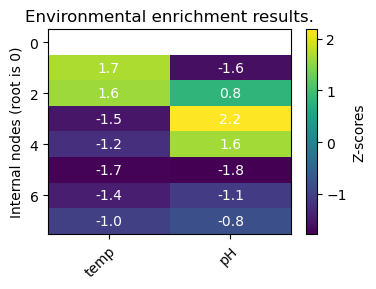

In [40]:
fig, ax = plt.subplots(figsize=(4,3), dpi=100)
im = ax.imshow(ZSCORES, aspect="auto")

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(FEATURES_NAMES)), labels=FEATURES_NAMES)
#ax.set_yticks(np.arange(len(vegetables)), labels=vegetables)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(ZSCORES.shape[0]):
    for j in range(len(FEATURES_NAMES)):
        text = ax.text(j, i, f"{ZSCORES[i, j]:0.1f}",
                       ha="center", va="center", color="w")

ax.set_ylabel("Internal nodes (root is 0)")
ax.set_title("Environmental enrichment results.")
fig.colorbar(im, label="Z-scores")
plt.tight_layout()
plt.show()

### 2. Filter significant nodes
In this section we will filter-out significant nodes whose parent is also significant. Note that we chose a Z_THRESHOLD = 1.0 just for ilustrative purposes. We **strongly** recommend that you choose a Z_THRESHOLD above 2.5.

In [41]:
# Related variables
Z_THRESHOLD = 1.0
ADJACENCY = fcutils.get_adjacency_matrix(FILENAME_TREE)

# Remove nans, substitute with 0s
X = ZSCORES.copy()
X[np.isnan(X)] = 0

# Clear output file
with open(FILENAME_OUT, 'w+', encoding="utf-8") as file:
    pass

# Accumulators
SIGNIFICANT = []

In [42]:
# For every feature
for feature_idx in range(FEATURES.shape[1]):

    # Local accumulator
    mrca_nodes = []

    # Find nodes that are significant
    nodes_sign = np.argwhere(np.abs(X[:, feature_idx]) > Z_THRESHOLD)[:, 0]

    for node_idx in nodes_sign:

        # Search parent
        parent_idc = np.argwhere(ADJACENCY[:, node_idx])[:, 0]
        # assert len(parent_idx) == 1

        # Add this node only when its parent is not significant...
        for p_idc in parent_idc:
            if np.abs(X[p_idc, feature_idx]) < Z_THRESHOLD:
                mrca_nodes.append(node_idx)

    print(f"\n---- {FEATURES_NAMES[feature_idx]} ----")
    print(f"Significant nodes: {len(nodes_sign)}")
    print("Significant nodes without significant parent:")
    _ = [print(f"  {_:4d} has {CLADE_NLEAFS[_]} leafs")
         for _ in mrca_nodes]

    # Show nodes that are contained in other significant nodes
    final_mrca_nodes = mrca_nodes.copy()
    for jj in mrca_nodes:
        jj_leafs = set(clade_lfs[jj])

        for kk in mrca_nodes:
            if jj == kk:
                continue
            kk_leafs = set(clade_lfs[kk])

            if kk_leafs.issubset(jj_leafs):
                if kk in final_mrca_nodes:
                    final_mrca_nodes.remove(kk)
                print(f'>> node {jj:4d} contains node {kk:4d}')

    # Export final_mrca_nodes if you wish to remove significant nodes whose
    # direct parent is not significant, but perhaps some other "secondary" or
    # more distant parent is again significant. From 70 to 50 entries in potF.
    SIGNIFICANT.append(final_mrca_nodes)
    # SIGNIFICANT.append(mrca_nodes)

idc_unique = np.unique([_ for a in SIGNIFICANT for _ in a])

print('\n----------------------------------')
print(f"Number of unique last parent significant nodes: {len(idc_unique)}.")



---- temp ----
Significant nodes: 7
Significant nodes without significant parent:
     1 has 2 leafs
     2 has 2 leafs
     4 has 2 leafs

---- pH ----
Significant nodes: 5
Significant nodes without significant parent:
     1 has 2 leafs
     4 has 2 leafs

----------------------------------
Number of unique last parent significant nodes: 3.


### 3. Clustering the phylogenetic tree

Show the proposed clustering as per previous results:

In [43]:
for jj, idx in enumerate(idc_unique):
    print(f"\n---- Cluster {jj+1} Clade #{idx} -----")
    print(f"Zscore pattern: {ZSCORES[idx,:]}")
    for leaf in clade_lfs[idx]:
        print("  " + GENUS[leaf], SPECIES[leaf])


---- Cluster 1 Clade #1 -----
Zscore pattern: [ 1.69382354 -1.61039344]
  Vibrio fictivorax
  Salmonella imagina

---- Cluster 2 Clade #2 -----
Zscore pattern: [1.60261648 0.80849894]
  Escherichia ficticola
  Mycobacterium fictum

---- Cluster 3 Clade #4 -----
Zscore pattern: [-1.21516587  1.63182256]
  Bacillus fictilis
  Acinetobacter imaginensis


##### Conclusions
Therefore there seems to be 3 clusters:
1. The first cluster contains orgnaisms whose habitat has a particularly high temperature and low pH
2. The second cluster corresponds to organisms that live in typically high temperature and "normal" pH
3. Last, the third cluster includes organisms that grow at low temperature and high pH.